<a href="https://colab.research.google.com/github/DanielaDSMS/AN2DL/blob/main/Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Artificial Neural Networks and Deep Learning**

---

## **Lecture 5: Timeseries Forecasting**

<img src="https://drive.google.com/uc?export=view&id=1Co7J09_1WY1kmurHm8SJPkxZw2_5s_tL" width="500"/>

## 🌐 **Google Drive Connection**

In [2]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/[2025-2026]\\ AN2DL/Lecture\\ 5"
%cd $current_dir

Mounted at /gdrive
[Errno 2] No such file or directory: '/gdrive/My Drive/[2025-2026] AN2DL/Lecture 5'
/content


## ⚙️ **Libraries Import**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [4]:
# Set environment variables for Air Quality dataset
os.environ["DATASET_NAME"] = "air_quality.csv"
os.environ["DATASET_URL"] = "1RQZbTbSsj-rL2Xc960VRge4cDmV0ByNf"

# Check if Air Quality dataset exists, download and unzip if not
if not os.path.exists(os.environ["DATASET_NAME"]):
    print("Downloading Air Quality dataset...")
    !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
    print("Air Quality dataset downloaded!")
else:
    print("Air Quality dataset already downloaded. Using cached data.")

Air Quality dataset downloaded!


## 🔎 **Exploration and Data Analysis**

In [5]:
# Load the dataset from a CSV file
dataset = pd.read_csv('air_quality.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset.shape}")

# Display the first few rows of the dataset
dataset.head()

Dataset shape: (43800, 3)


,dew,temperature,pression
0,-16,-4.0,1020.0
1,-15,-4.0,1020.0
2,-11,-5.0,1021.0
3,-7,-5.0,1022.0
4,-7,-5.0,1022.0


In [6]:
# Display a summary of the dataset's structure and data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  int64  
 1   temperature  43800 non-null  float64
 2   pression     43800 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 1.0 MB


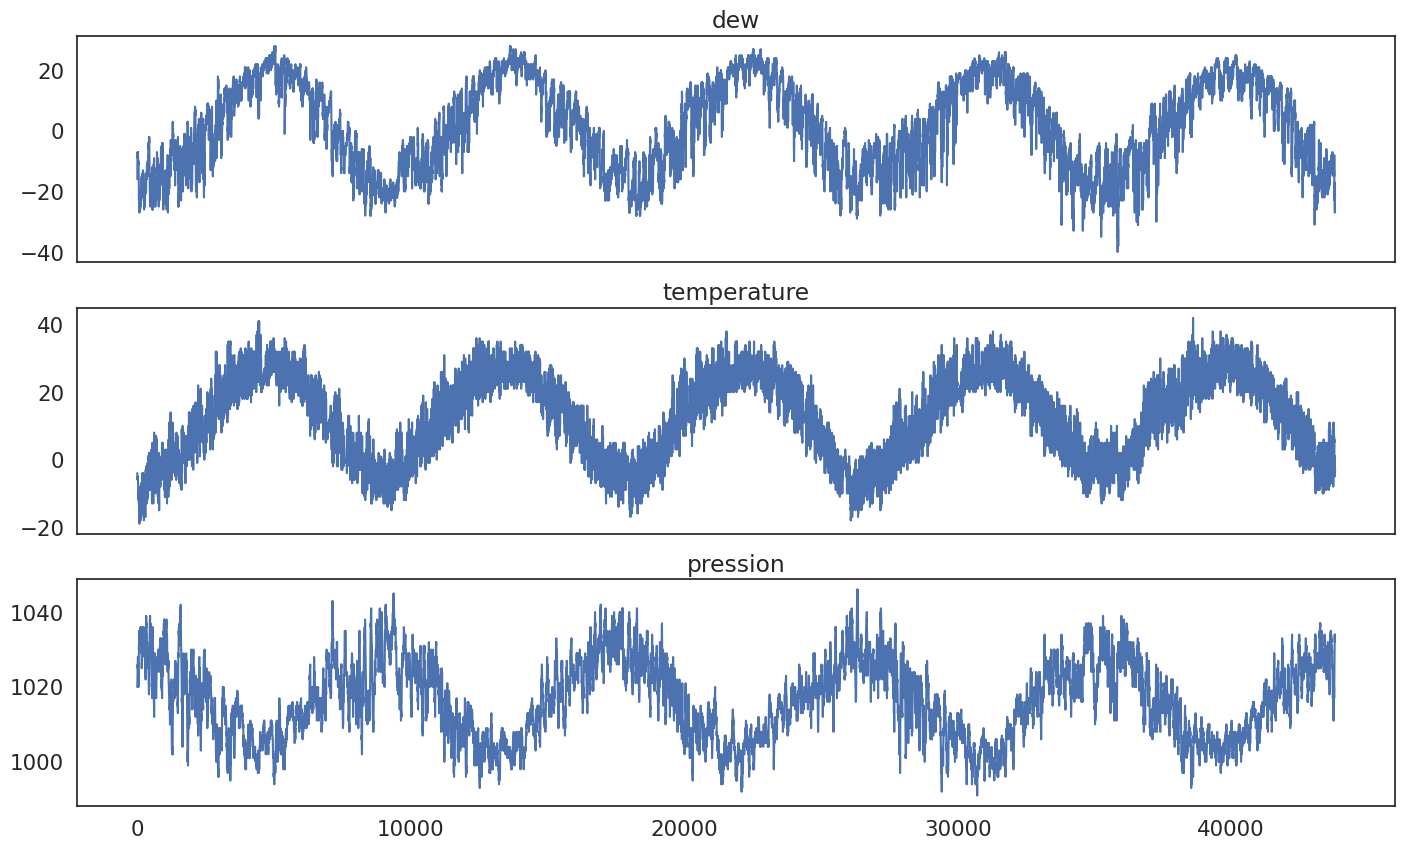

In [7]:
# Define a function to plot and inspect specified columns of a dataframe
def inspect_dataframe(df, columns):
    # Create subplots for each column
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through the specified columns and plot each
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)

    # Display the plots
    plt.show()

# Call the function to inspect all columns of the dataset
inspect_dataframe(dataset, dataset.columns)

## 🔄 **Data Preprocessing**

In [8]:
# Convert 'dew' column to float32
dataset['dew'] = dataset['dew'].astype(np.float32)

# Convert 'temperature' column to float32
dataset['temperature'] = dataset['temperature'].astype(np.float32)

# Convert 'pression' column to float32
dataset['pression'] = dataset['pression'].astype(np.float32)

# Display updated dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dew          43800 non-null  float32
 1   temperature  43800 non-null  float32
 2   pression     43800 non-null  float32
dtypes: float32(3)
memory usage: 513.4 KB


In [9]:
# Define sizes for validation and test sets
val_size = 2850
test_size = 2850

# Split the dataset into training, validation, and test sets
X_train_raw = dataset.iloc[:-val_size-test_size]
X_val_raw = dataset.iloc[-val_size-test_size:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# Print the shapes of the split datasets
print(f"Train set shape: {X_train_raw.shape}")
print(f"Validation set shape: {X_val_raw.shape}")
print(f"Test set shape: {X_test_raw.shape}")

# Normalise data using training set statistics
X_min = X_train_raw.min()
X_max = X_train_raw.max()

# Apply min-max normalisation
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)
X_val_raw = (X_val_raw - X_min) / (X_max - X_min)
X_test_raw = (X_test_raw - X_min) / (X_max - X_min)

Train set shape: (38100, 3)
Validation set shape: (2850, 3)
Test set shape: (2850, 3)


In [10]:
# Define target labels as the column names of the dataset
TARGET_LABELS = dataset.columns

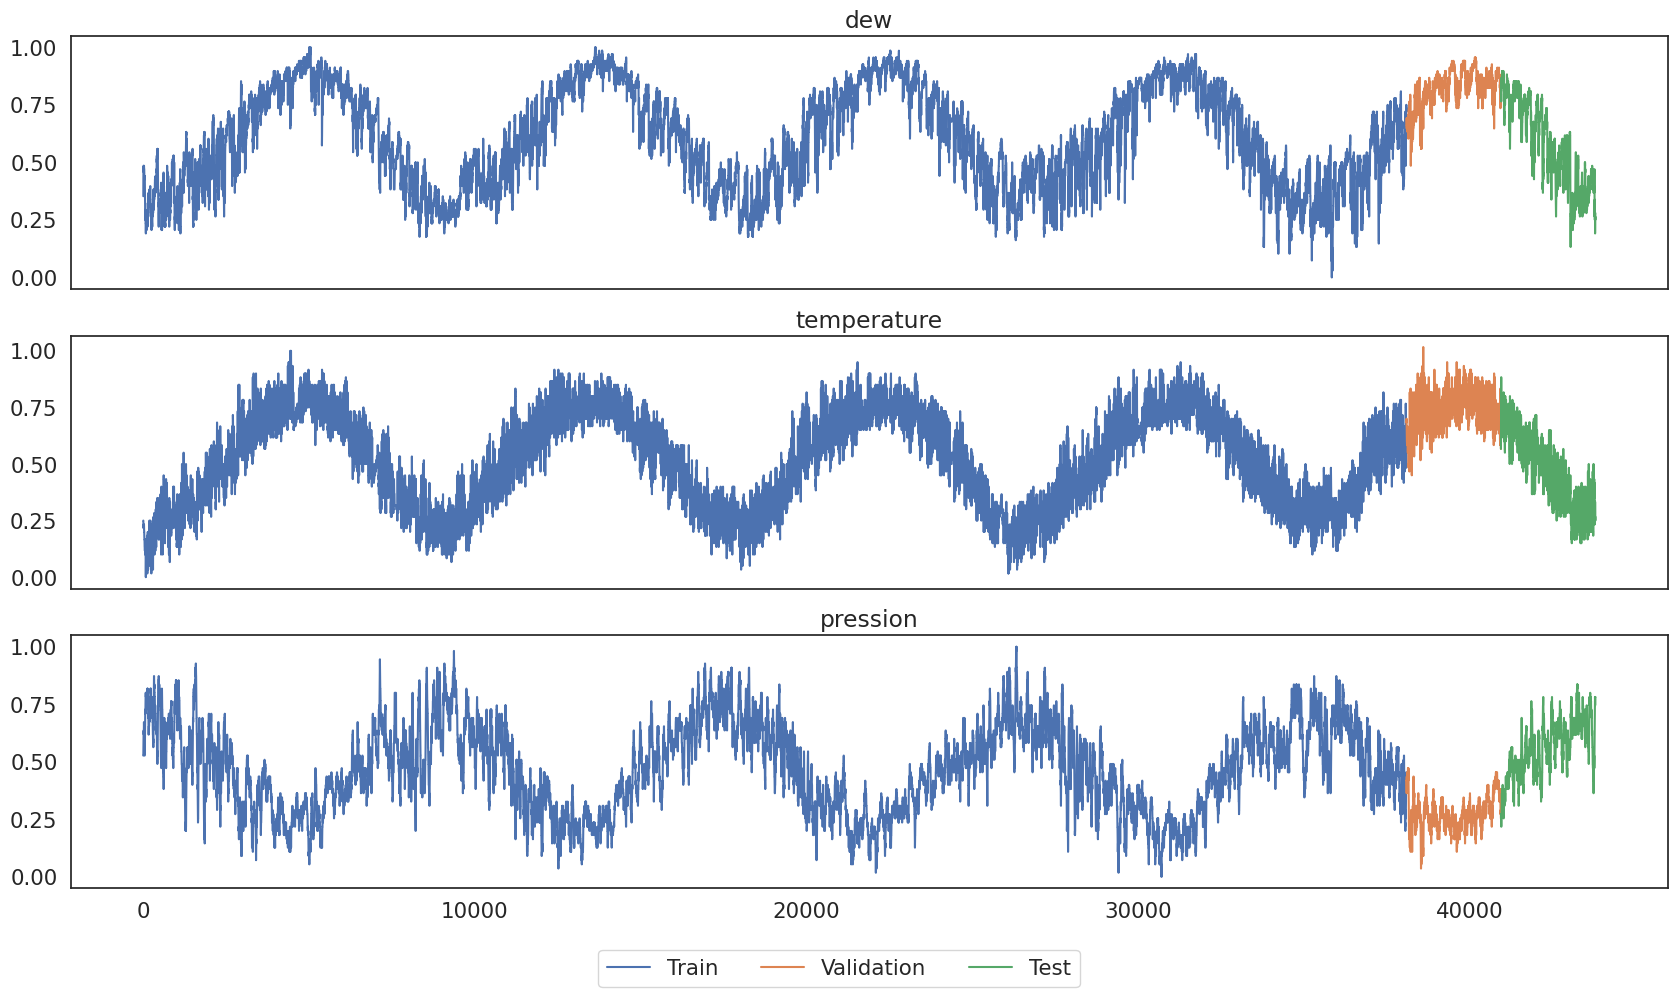

In [11]:
# Define a function to inspect and compare data splits
def inspect_splits(X_train, X_val, X_test, columns):
    # Create subplots for each column
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Plot train, validation, and test data for each column
    for i, col in enumerate(columns):
        axs[i].plot(X_train[col], label='Train')
        axs[i].plot(X_val[col], label='Validation')
        axs[i].plot(X_test[col], label='Test')
        axs[i].set_title(col)

    # Add a single legend below all subplots
    handles, labels = axs[0].get_legend_handles_labels()
    figs.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.02),
                ncol=3, borderaxespad=0.)

    # Adjust layout to prevent legend overlap
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

# Inspect splits across all target labels
inspect_splits(X_train_raw, X_val_raw, X_test_raw, TARGET_LABELS)

In [12]:
# Define window size for time-series data
WINDOW_SIZE = 800

# Define stride length for window movement
STRIDE = 5

# Define telescope size for prediction horizon
TELESCOPE_SIZE = 50

In [13]:
# Extract the last 'WINDOW_SIZE' rows of the dataset for future prediction
future = dataset[-WINDOW_SIZE:]

# Normalise the future data using training set statistics
future = (future - X_min) / (X_max - X_min)

# Expand dimensions to prepare for model input
future = np.expand_dims(future, axis=0)

# Print the shape of the prepared future data
future.shape

(1, 800, 3)

In [14]:
# Define a function to build sequences and corresponding labels from a dataframe
def build_sequences(df, target_labels=['temperature'], window=200, stride=20, telescope=100):
    # Ensure the window size is compatible with the stride
    assert window % stride == 0

    # Initialise containers for dataset sequences and labels
    dataset = []
    labels = []

    # Copy dataframe values for processing
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values

    # Check for and handle padding requirement
    padding_check = len(df) % window
    if padding_check != 0:
        # Compute padding length
        padding_len = window - len(df) % window

        # Add zero-padding to features and labels
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding, temp_df))

        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))

        # Verify that the padded data length is divisible by the window size
        assert len(temp_df) % window == 0

    # Create sequences and corresponding labels
    for idx in np.arange(0, len(temp_df) - window - telescope, stride):
        dataset.append(temp_df[idx:idx + window])
        labels.append(temp_label[idx + window:idx + window + telescope])

    # Convert lists to numpy arrays
    dataset = np.array(dataset)
    labels = np.array(labels)

    # Return the dataset and labels
    return dataset, labels

## 🛠️ **Multivariate Forecating (Direct)**

In [15]:
# Define direct telescope size for prediction horizon
direct_telescope = TELESCOPE_SIZE

In [16]:
# Build sequences and labels for training, validation, and test datasets
X_train, y_train = build_sequences(X_train_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, direct_telescope)
X_val, y_val = build_sequences(X_val_raw, TARGET_LABELS, WINDOW_SIZE, 1, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, TARGET_LABELS, WINDOW_SIZE, 1, direct_telescope)

# Print the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7510, 800, 3),
 (7510, 50, 3),
 (2350, 800, 3),
 (2350, 50, 3),
 (2350, 800, 3),
 (2350, 50, 3))

In [17]:
# Define a function to inspect multivariate sequences and predictions
def inspect_multivariate(X, y, columns, telescope, idx=None):
    # Select a random index if none is provided
    if idx is None:
        idx = np.random.randint(0, len(X))

    # Create subplots for visualisation
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through each column and plot the sequence and target predictions
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0, :, i]), len(X[0, :, i]) + telescope),
                       y[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)

    # Display the plots
    plt.show()

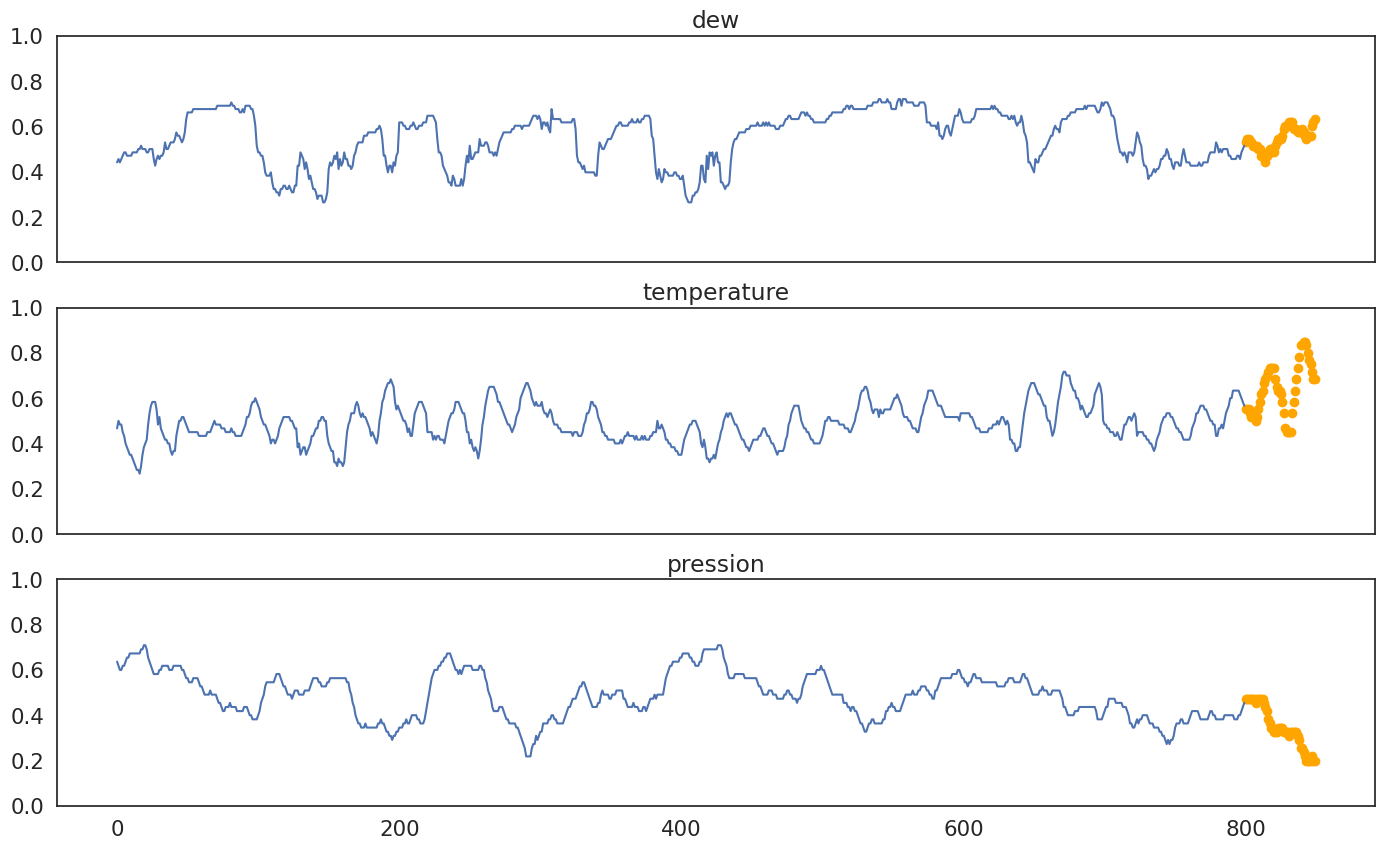

In [18]:
# Inspect multivariate sequences and predictions using the training data
inspect_multivariate(X_train, y_train, TARGET_LABELS, direct_telescope)

In [19]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the output shape based on the training labels
output_shape = y_train.shape[1:]

In [20]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [21]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 128

In [22]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [23]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [24]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 800, 3])
Labels batch shape: torch.Size([128, 50, 3])


## 🛠️ **Model Building**

In [25]:
# @title recurrent_summary()
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [26]:
class RecurrentForecaster(nn.Module):
    """
    Generic RNN model (RNN, LSTM, GRU) for forecasting.
    Uses the last hidden state of the RNN to predict a future sequence.
    (Many-to-One -> One-to-Many approach)
    """
    def __init__(
            self,
            input_size,       # Number of features in the input (e.g., 6 for air quality)
            hidden_size,      # Hidden state size
            num_layers,       # Number of stacked RNN layers
            output_timesteps, # Number of future timesteps to predict (e.g., 12)
            output_features,  # Number of features to predict (e.g., 1 for 'PM2.5' only, 6 for all)
            rnn_type='GRU',   # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.output_timesteps = output_timesteps
        self.output_features = output_features

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # --- Recurrent Block (GRU) ---
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,      # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final MLP
        if self.bidirectional:
            mlp_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            mlp_input_size = hidden_size

        # --- MLP Block (Forecaster) ---
        # This layer projects the last hidden state onto the entire future sequence
        self.forecaster = nn.Linear(mlp_input_size, output_timesteps * output_features)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)
        rnn_out, hidden = self.rnn(x)

        # If it's an LSTM, hidden is a tuple (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # Extract the last hidden state from the last layer
        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # Concatenate the last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            rnn_last_state = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the hidden state from the last layer
            # Final shape: (batch_size, hidden_size)
            rnn_last_state = hidden[-1]

        # --- Projection to Future ---
        # Pass the last state (the "summary" of the sequence) through the MLP
        # prediction shape: (batch_size, output_timesteps * output_features)
        prediction = self.forecaster(rnn_last_state)

        # Reshape the output to match the target (e.g., [B, 12, 1] or [B, 12, 6])
        batch_size = x.size(0)
        prediction = prediction.view(batch_size, self.output_timesteps, self.output_features)

        return prediction

In [27]:
forecast_model = RecurrentForecaster(
    input_size=input_shape[1],              # Number of features in the input
    hidden_size=128,                        # Equivalent to 128 units in Keras
    num_layers=1,                           # Equivalent to the two LSTM layers
    output_timesteps=output_shape[0],
    output_features=output_shape[1],        # We predict all features
    dropout_rate=0.2,                       # Dropout between GRU layers (if num_layers > 1)
    rnn_type='LSTM',
    bidirectional=False
).to(device)

# Show summary (requires torchinfo)
# (batch_size, seq_len, input_size)
recurrent_summary(forecast_model, input_size=(input_shape[0], input_shape[1]))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 800, 128], [1, -1, 128]] 68,096         
forecaster (Linear)       [-1, 150]                    19,350         
Total params: 87,446
Trainable params: 87,446
Non-trainable params: 0
-------------------------------------------------------------------------------


## 🧮 **Network and Training Hyperparameters**

In [28]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 1        # Hidden layers
HIDDEN_SIZE = 256        # Neurons per layer
MODEL_TYPE = 'LSTM'      # RNN, LSTM, or GRU
BIDIRECTIONAL = False    # Use bidirectional RNN layers

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.MSELoss()

## 🧠 **Model Training**

In [29]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.
    Adapted for Regression (Forecasting).
    Calculates and reports RMSE.
    Optimizes on the provided criterion (assumed to be MSELoss).

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        float: average_rmse - Training RMSE for this epoch
    """
    model.train()  # Set model to training mode

    running_mse_loss = 0.0

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            predictions = model(inputs)
            # Calculate the loss (e.G., MSE)
            loss = criterion(predictions, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        # We store the *squared* error (MSE) from the loss function
        running_mse_loss += loss.item() * inputs.size(0)

    # Calculate epoch metrics
    epoch_mse = running_mse_loss / len(train_loader.dataset)
    epoch_rmse = np.sqrt(epoch_mse) # Convert final MSE to RMSE for reporting

    return epoch_rmse


def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.
    Adapted for Regression (Forecasting).
    Calculates and reports RMSE.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss (e.g., MSELoss)
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        float: average_rmse - Validation RMSE for this epoch
    """
    model.eval()  # Set model to evaluation mode

    running_mse_loss = 0.0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                predictions = model(inputs)
                # Calculate the loss (e.g., MSE)
                loss = criterion(predictions, targets)

            # Accumulate metrics
            running_mse_loss += loss.item() * inputs.size(0)

    # Calculate epoch metrics
    epoch_mse = running_mse_loss / len(val_loader.dataset)
    epoch_rmse = np.sqrt(epoch_mse) # Convert final MSE to RMSE for reporting

    return epoch_rmse


def log_metrics_to_tensorboard(writer, epoch, train_rmse, val_rmse, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.
    Adapted for Regression (Forecasting) metrics (RMSE only).

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_rmse (float): Training RMSE for this epoch
        val_rmse (float): Validation RMSE for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)
    """
    # Log scalar metrics
    writer.add_scalar('RMSE/Training', train_rmse, epoch)
    writer.add_scalar('RMSE/Validation', val_rmse, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, scheduler=None, # Added scheduler parameter
        evaluation_metric="val_rmse", mode='min', # Monitors val_rmse and minimizes
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.
    Adapted for Regression (Forecasting), using RMSE as the sole metric.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler (default: None)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_rmse")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'min')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Ensure models directory exists
    if (patience > 0 or restore_best_weights) and not os.path.exists("models"):
        os.makedirs("models")
        print("Created 'models' directory for saving model checkpoints.")

    model_path = os.path.join("models", f"{experiment_name}_model.pt")

    # Initialize metrics tracking
    training_history = {
        'train_rmse': [], 'val_rmse': [], 'lr': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('inf') if mode == 'min' else float('-inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_rmse = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_rmse = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Step the scheduler if provided (typically after validation)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_rmse)
            else:
                scheduler.step()


        # Store metrics for plotting and analysis
        training_history['train_rmse'].append(train_rmse)
        training_history['val_rmse'].append(val_rmse)
        training_history['lr'].append(optimizer.param_groups[0]['lr'])


        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_rmse, val_rmse, model
            )
            # Log learning rate
            writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: RMSE={train_rmse:.4f} | "
                      f"Val: RMSE={val_rmse:.4f} | "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")


        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            # We monitor the metric specified in 'evaluation_metric' (default: 'val_rmse')
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric < best_metric) if mode == 'min' else (current_metric > best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        try:
            model.load_state_dict(torch.load(model_path))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
            print(f"Warning: Could not find best model checkpoint at {model_path}. Using last model.")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), model_path)

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [30]:
rnn_model = RecurrentForecaster(
    input_size=input_shape[1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    output_timesteps=output_shape[0],
    output_features=output_shape[1],
    dropout_rate=DROPOUT_RATE,
    rnn_type=MODEL_TYPE,
    bidirectional=BIDIRECTIONAL
).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "direct_lstm_forecaster_50"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 800, 256], [1, -1, 256]] 267,264        
forecaster (Linear)       [-1, 150]                    38,550         
Total params: 305,814
Trainable params: 305,814
Non-trainable params: 0
-------------------------------------------------------------------------------


In [31]:
%%time
# Train model and track training history
# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Monitor a metric that should be minimized (RMSE)
    factor=0.1,        # Factor by which the learning rate will be reduced
    patience=max(10,PATIENCE//2),       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6        # Minimum learning rate
)

rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    patience=PATIENCE,
    evaluation_metric="val_rmse",
    mode='min',
    restore_best_weights=True,
    writer=writer,  # Set to writer if you want TensorBoard logging
    verbose=1,
    experiment_name="direct_lstm_forecaster_50",
    scheduler=scheduler # Pass the scheduler to the fit function
)

Training 500 epochs...
Epoch   1/500 | Train: RMSE=0.2549 | Val: RMSE=0.1144 | LR: 0.001000
Epoch   2/500 | Train: RMSE=0.1001 | Val: RMSE=0.0678 | LR: 0.001000
Epoch   3/500 | Train: RMSE=0.0900 | Val: RMSE=0.0624 | LR: 0.001000
Epoch   4/500 | Train: RMSE=0.0890 | Val: RMSE=0.0611 | LR: 0.001000
Epoch   5/500 | Train: RMSE=0.0877 | Val: RMSE=0.0617 | LR: 0.001000
Epoch   6/500 | Train: RMSE=0.0867 | Val: RMSE=0.0616 | LR: 0.001000
Epoch   7/500 | Train: RMSE=0.0863 | Val: RMSE=0.0629 | LR: 0.001000
Epoch   8/500 | Train: RMSE=0.0865 | Val: RMSE=0.0598 | LR: 0.001000
Epoch   9/500 | Train: RMSE=0.0849 | Val: RMSE=0.0594 | LR: 0.001000
Epoch  10/500 | Train: RMSE=0.0846 | Val: RMSE=0.0633 | LR: 0.001000
Epoch  11/500 | Train: RMSE=0.0814 | Val: RMSE=0.0576 | LR: 0.001000
Epoch  12/500 | Train: RMSE=0.0803 | Val: RMSE=0.0583 | LR: 0.001000
Epoch  13/500 | Train: RMSE=0.0785 | Val: RMSE=0.0552 | LR: 0.001000
Epoch  14/500 | Train: RMSE=0.0764 | Val: RMSE=0.0513 | LR: 0.001000
Epoch  15/5

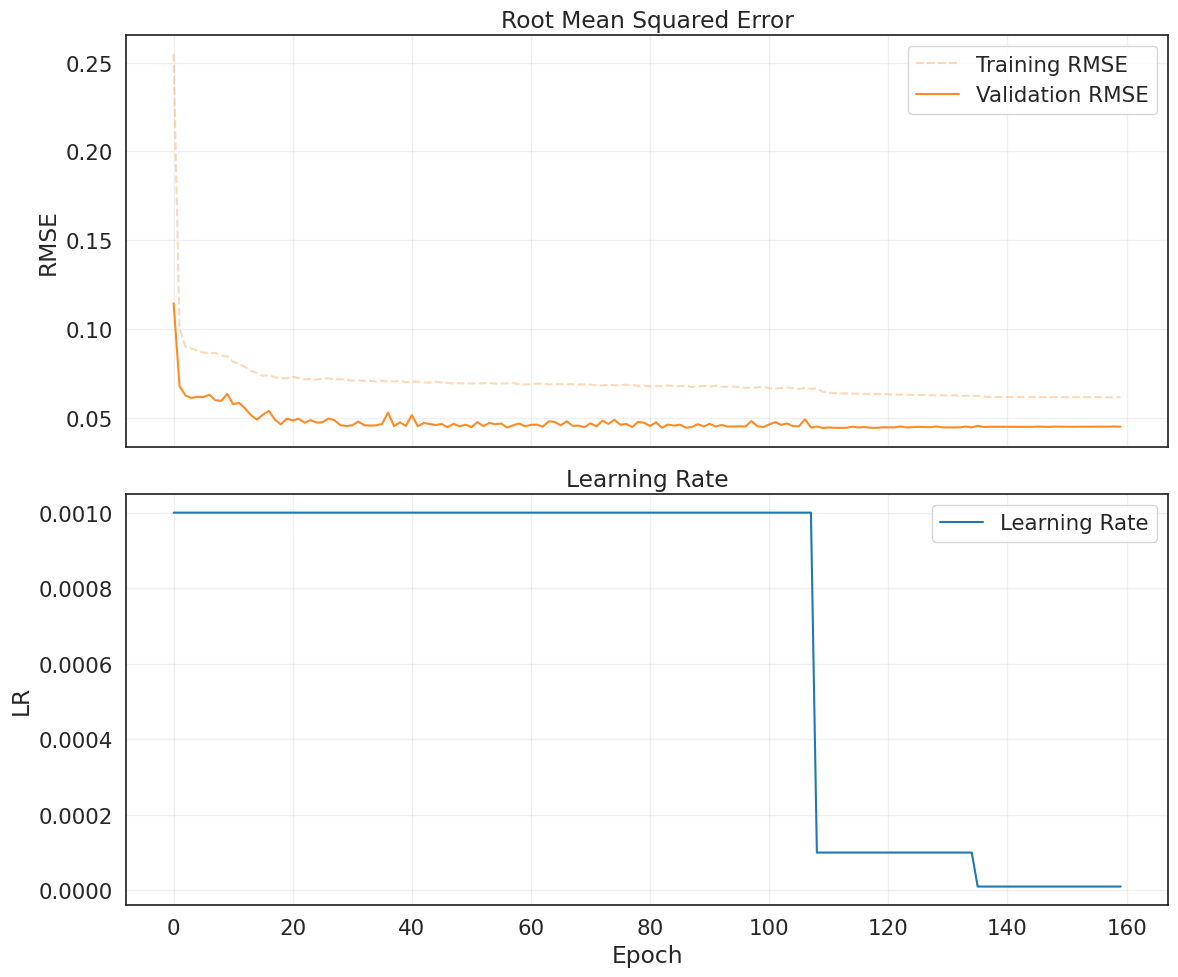

In [32]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 10))

# Plot of training and validation RMSE
ax1.plot(training_history['train_rmse'], label='Training RMSE', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_rmse'], label='Validation RMSE', alpha=0.9, color='#ff7f0e')
ax1.set_title('Root Mean Squared Error')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of Learning Rate
ax2.plot(training_history['lr'], label='Learning Rate', color='#1f77b4')
ax2.set_title('Learning Rate')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('LR')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Validation Performance:
  RMSE: 0.044173


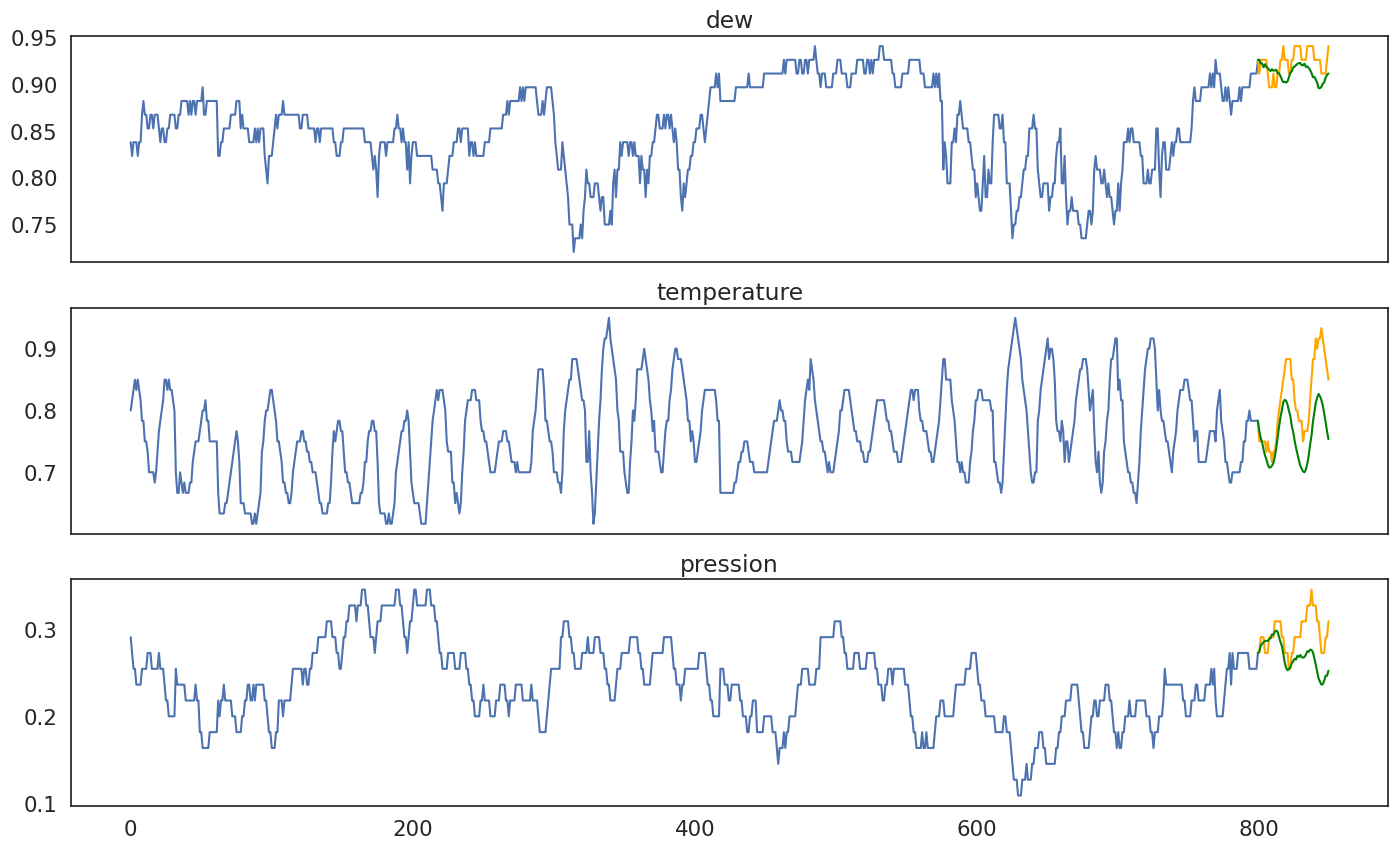

In [33]:
# Define a function to inspect multivariate predictions versus ground truth
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    # Select a random index if none is provided
    if idx is None:
        idx = np.random.randint(0, len(X))

    # Prepare prediction and ground truth by concatenating the last known point
    pred = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), pred], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), y], axis=1)

    # Create subplots for visualisation
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through each column and plot actual, true, and predicted values
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])  # Plot historical data
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    y[idx, :, i], color='orange', label='Ground Truth')  # Plot ground truth
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    pred[idx, :, i], color='green', label='Prediction')  # Plot predictions
        axs[i].set_title(col)

    # Display the plots
    plt.show()

# Make predictions on validation set
rnn_model.eval()
val_predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        preds = rnn_model(inputs)
        val_predictions.append(preds.cpu().numpy())

# Concatenate all predictions
val_predictions = np.concatenate(val_predictions, axis=0)

# Calculate validation performance
val_mse = np.mean((val_predictions - y_val) ** 2)
val_rmse = np.sqrt(val_mse)

print(f"Validation Performance:")
print(f"  RMSE: {val_rmse:.6f}")

# Inspect multivariate predictions versus ground truth using the validation data
inspect_multivariate_prediction(X_val, y_val, val_predictions, TARGET_LABELS, direct_telescope)

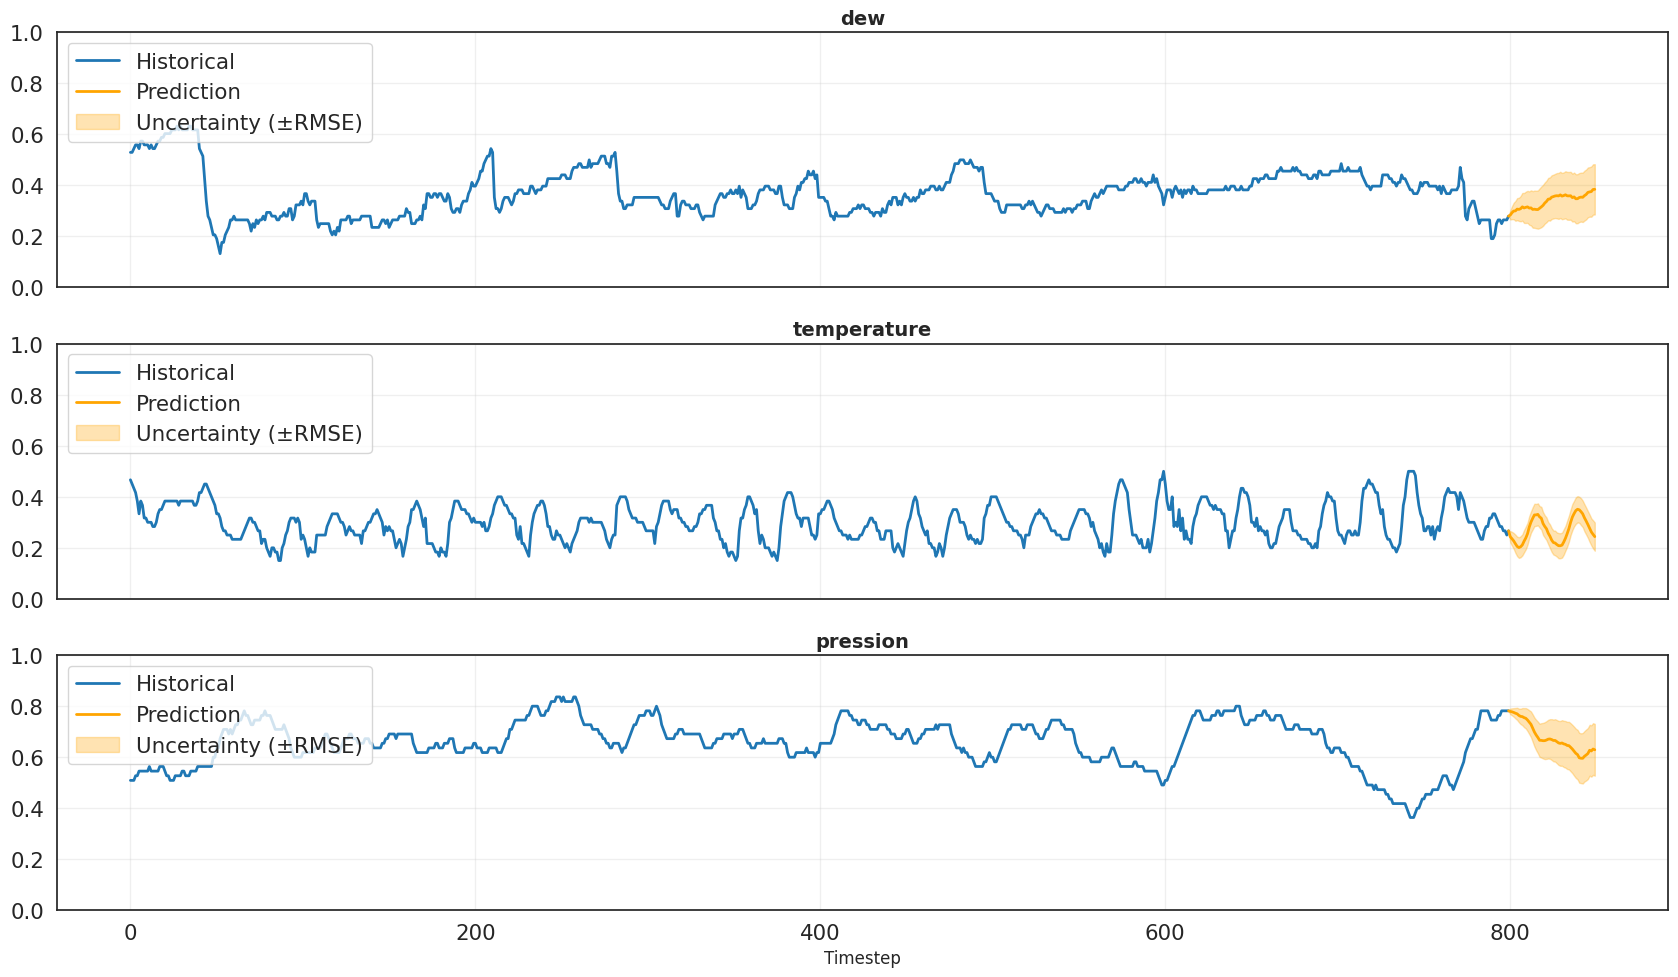

In [34]:
# ========================================
# Predictions on test set using Direct Forecasting model
# ========================================
X_test_direct, y_test_direct = build_sequences(
    X_test_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, direct_telescope
)
test_ds_direct = TensorDataset(torch.from_numpy(X_test_direct), torch.from_numpy(y_test_direct))
test_loader_direct = make_loader(test_ds_direct, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

rnn_model.eval()
test_predictions = []

with torch.no_grad():
    for inputs, _ in test_loader_direct:
        inputs = inputs.to(device)
        preds = rnn_model(inputs)
        test_predictions.append(preds.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)

# ========================================
# Compute RMSE per timestep and feature
# ========================================
rmses = []
for i in range(test_predictions.shape[1]):
    ft_rmses = []
    for j in range(test_predictions.shape[2]):
        mse = np.mean((y_test_direct[:, i, j] - test_predictions[:, i, j]) ** 2)
        rmse = np.sqrt(mse)
        ft_rmses.append(rmse)
    rmses.append(np.array(ft_rmses))

rmses = np.array(rmses)

# ========================================
# Generate future predictions
# ========================================
future_predictions = rnn_model(torch.from_numpy(future).to(device))
future_predictions = future_predictions.cpu().detach().numpy()

future_predictions = np.concatenate(
    [np.expand_dims(future[:, -1, :], axis=1), future_predictions],
    axis=1
)

rmses = np.concatenate([np.array([[0, 0, 0]]), rmses], axis=0)

# ========================================
# Visualize future predictions with uncertainty bounds
# ========================================
figs, axs = plt.subplots(len(TARGET_LABELS), 1, sharex=True, figsize=(17, 10))

for i, col in enumerate(TARGET_LABELS):
    axs[i].plot(
        np.arange(len(future[0, :, i])),
        future[0, :, i],
        label='Historical',
        color='#1f77b4',
        linewidth=2
    )

    axs[i].plot(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i],
        color='orange',
        label='Prediction',
        linewidth=2
    )

    axs[i].fill_between(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i] + rmses[:, i],
        future_predictions[0, :, i] - rmses[:, i],
        color='orange',
        alpha=0.3,
        label='Uncertainty (±RMSE)'
    )

    axs[i].set_title(col, fontsize=14, fontweight='bold')
    axs[i].set_ylim(0, 1)
    axs[i].grid(alpha=0.3)
    axs[i].legend(loc='upper left')

plt.xlabel('Timestep', fontsize=12)
plt.tight_layout()
plt.show()

## 🛠️ **Multivariate Forecating (Autoregressive)**

In [35]:
# Define autoregressive telescope size for prediction horizon
autoregressive_telescope = 10

assert autoregressive_telescope <= WINDOW_SIZE, "Telescope size must be less than or equal to window size."

In [36]:
# Build sequences and labels for training, validation, and test datasets
X_train, y_train = build_sequences(X_train_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, autoregressive_telescope)
X_val, y_val = build_sequences(X_val_raw, TARGET_LABELS, WINDOW_SIZE, 1, autoregressive_telescope)
X_test, y_test = build_sequences(X_test_raw, TARGET_LABELS, WINDOW_SIZE, 1, autoregressive_telescope)

# Print the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7518, 800, 3),
 (7518, 10, 3),
 (2390, 800, 3),
 (2390, 10, 3),
 (2390, 800, 3),
 (2390, 10, 3))

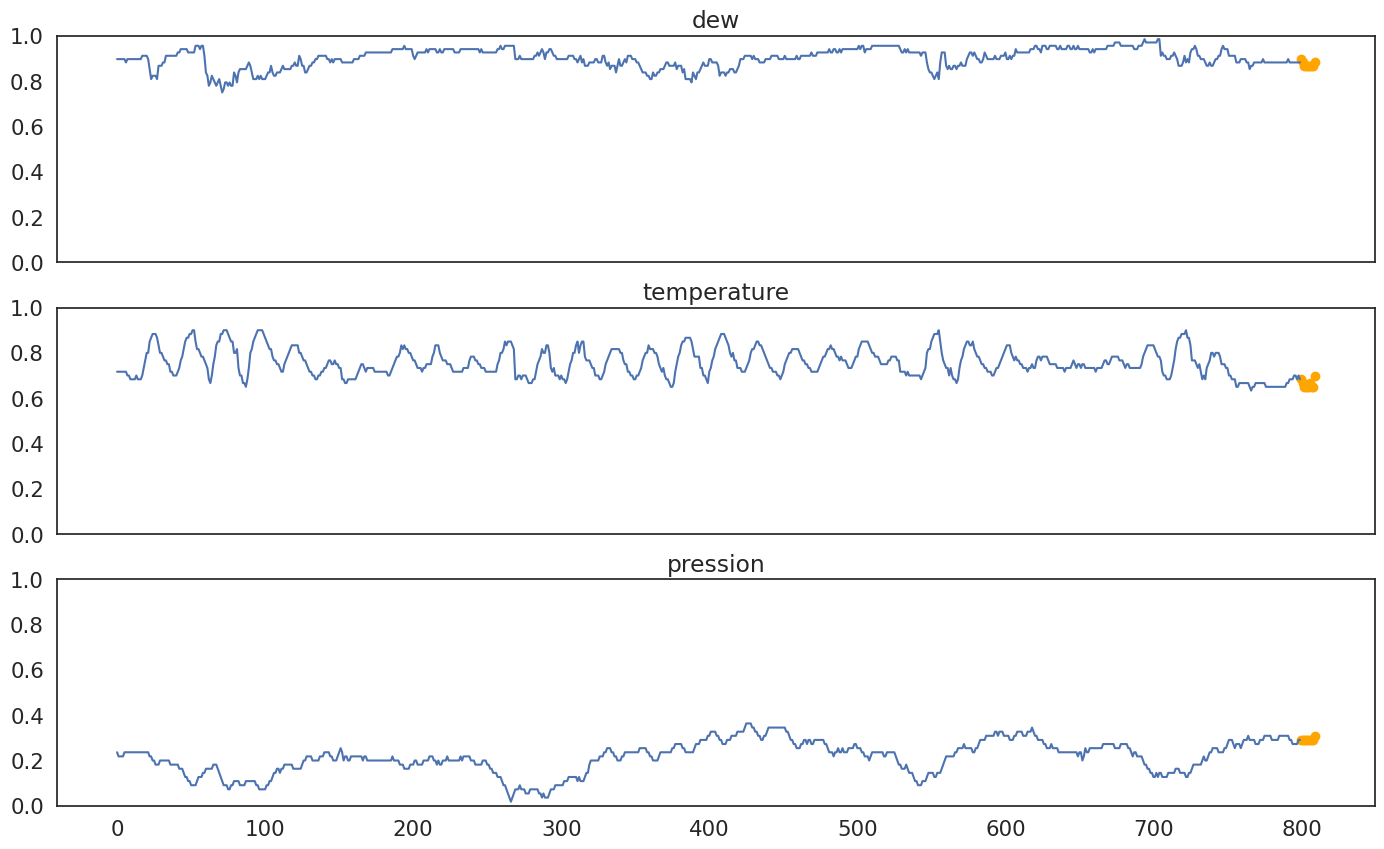

In [37]:
# Inspect multivariate sequences and predictions using the training data
inspect_multivariate(X_train, y_train, TARGET_LABELS, autoregressive_telescope)

In [38]:
# Define the output shape based on the training labels
output_shape = y_train.shape[1:]

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 800, 3])
Labels batch shape: torch.Size([128, 10, 3])


In [39]:
rnn_model = RecurrentForecaster(
    input_size=input_shape[1],  # Number of features in the input
    hidden_size=HIDDEN_SIZE,          # Equivalent to 128 units in Keras
    num_layers=HIDDEN_LAYERS,             # Equivalent to the two LSTM layers
    output_timesteps=output_shape[0],
    output_features=output_shape[1], # We predict all features
    dropout_rate=DROPOUT_RATE,         # Dropout between GRU layers (if num_layers > 1)
    rnn_type=MODEL_TYPE,
    bidirectional=BIDIRECTIONAL
).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "autoregressive_lstm_forecaster_50"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 800, 256], [1, -1, 256]] 267,264        
forecaster (Linear)       [-1, 30]                     7,710          
Total params: 274,974
Trainable params: 274,974
Non-trainable params: 0
-------------------------------------------------------------------------------


In [40]:
%%time
# Train model and track training history
# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Monitor a metric that should be minimized (RMSE)
    factor=0.1,        # Factor by which the learning rate will be reduced
    patience=max(10,PATIENCE//2),       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6        # Minimum learning rate
)

rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    patience=PATIENCE,
    evaluation_metric="val_rmse",
    mode='min',
    restore_best_weights=True,
    writer=writer,  # Set to writer if you want TensorBoard logging
    verbose=1,
    experiment_name="autoregressive_lstm_forecaster_50",
    scheduler=scheduler # Pass the scheduler to the fit function
)

Training 500 epochs...
Epoch   1/500 | Train: RMSE=0.2987 | Val: RMSE=0.2131 | LR: 0.001000
Epoch   2/500 | Train: RMSE=0.1264 | Val: RMSE=0.0671 | LR: 0.001000
Epoch   3/500 | Train: RMSE=0.0819 | Val: RMSE=0.0611 | LR: 0.001000
Epoch   4/500 | Train: RMSE=0.0791 | Val: RMSE=0.0613 | LR: 0.001000
Epoch   5/500 | Train: RMSE=0.0772 | Val: RMSE=0.0589 | LR: 0.001000
Epoch   6/500 | Train: RMSE=0.0730 | Val: RMSE=0.0585 | LR: 0.001000
Epoch   7/500 | Train: RMSE=0.0698 | Val: RMSE=0.0580 | LR: 0.001000
Epoch   8/500 | Train: RMSE=0.0690 | Val: RMSE=0.0548 | LR: 0.001000
Epoch   9/500 | Train: RMSE=0.0679 | Val: RMSE=0.0564 | LR: 0.001000
Epoch  10/500 | Train: RMSE=0.0671 | Val: RMSE=0.0568 | LR: 0.001000
Epoch  11/500 | Train: RMSE=0.0656 | Val: RMSE=0.0521 | LR: 0.001000
Epoch  12/500 | Train: RMSE=0.0634 | Val: RMSE=0.0527 | LR: 0.001000
Epoch  13/500 | Train: RMSE=0.0622 | Val: RMSE=0.0505 | LR: 0.001000
Epoch  14/500 | Train: RMSE=0.0588 | Val: RMSE=0.0517 | LR: 0.001000
Epoch  15/5

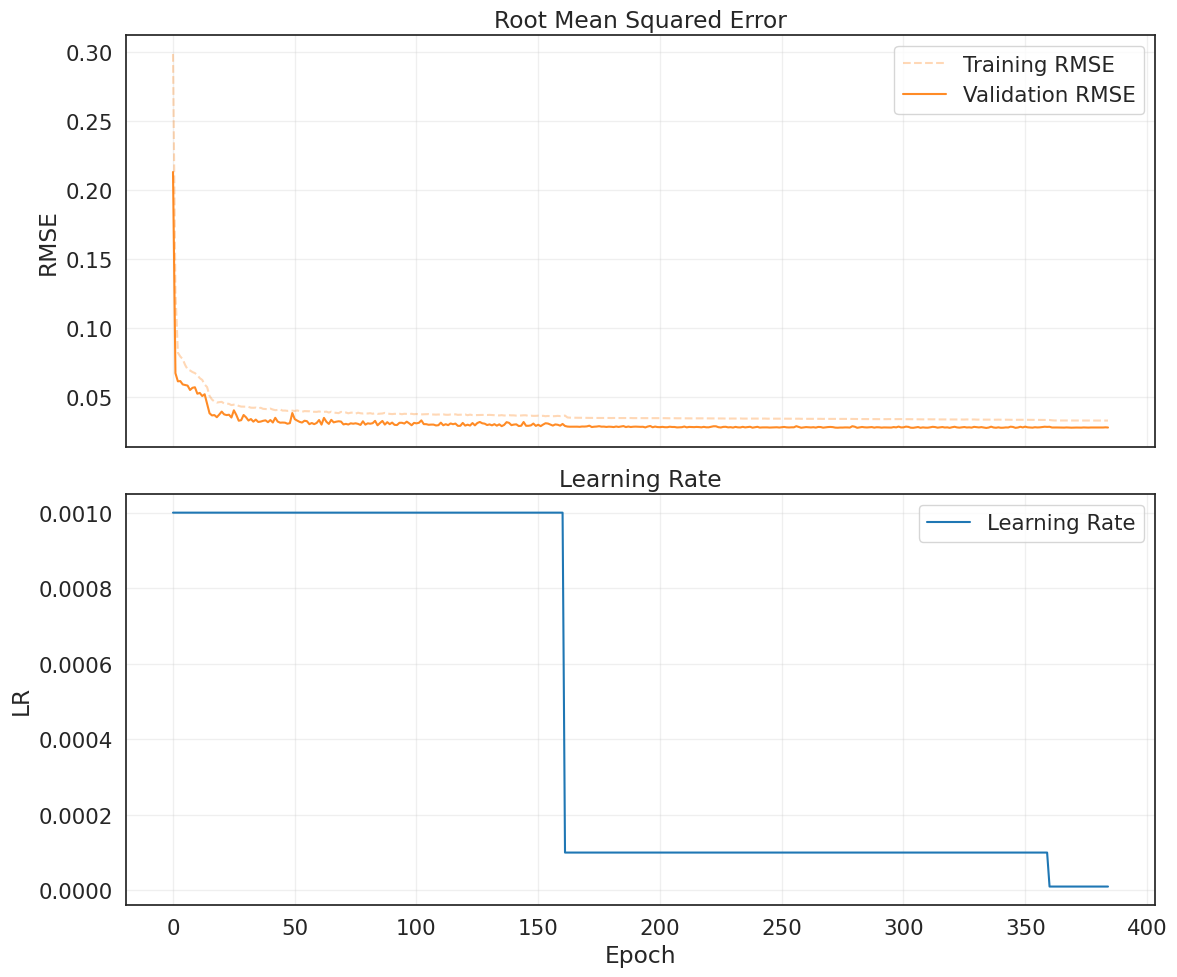

In [41]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 10))

# Plot of training and validation RMSE
ax1.plot(training_history['train_rmse'], label='Training RMSE', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_rmse'], label='Validation RMSE', alpha=0.9, color='#ff7f0e')
ax1.set_title('Root Mean Squared Error')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of Learning Rate
ax2.plot(training_history['lr'], label='Learning Rate', color='#1f77b4')
ax2.set_title('Learning Rate')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('LR')
ax2.legend()
ax2.grid(alpha=0.3)


# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Validation Performance:
  RMSE: 0.043557


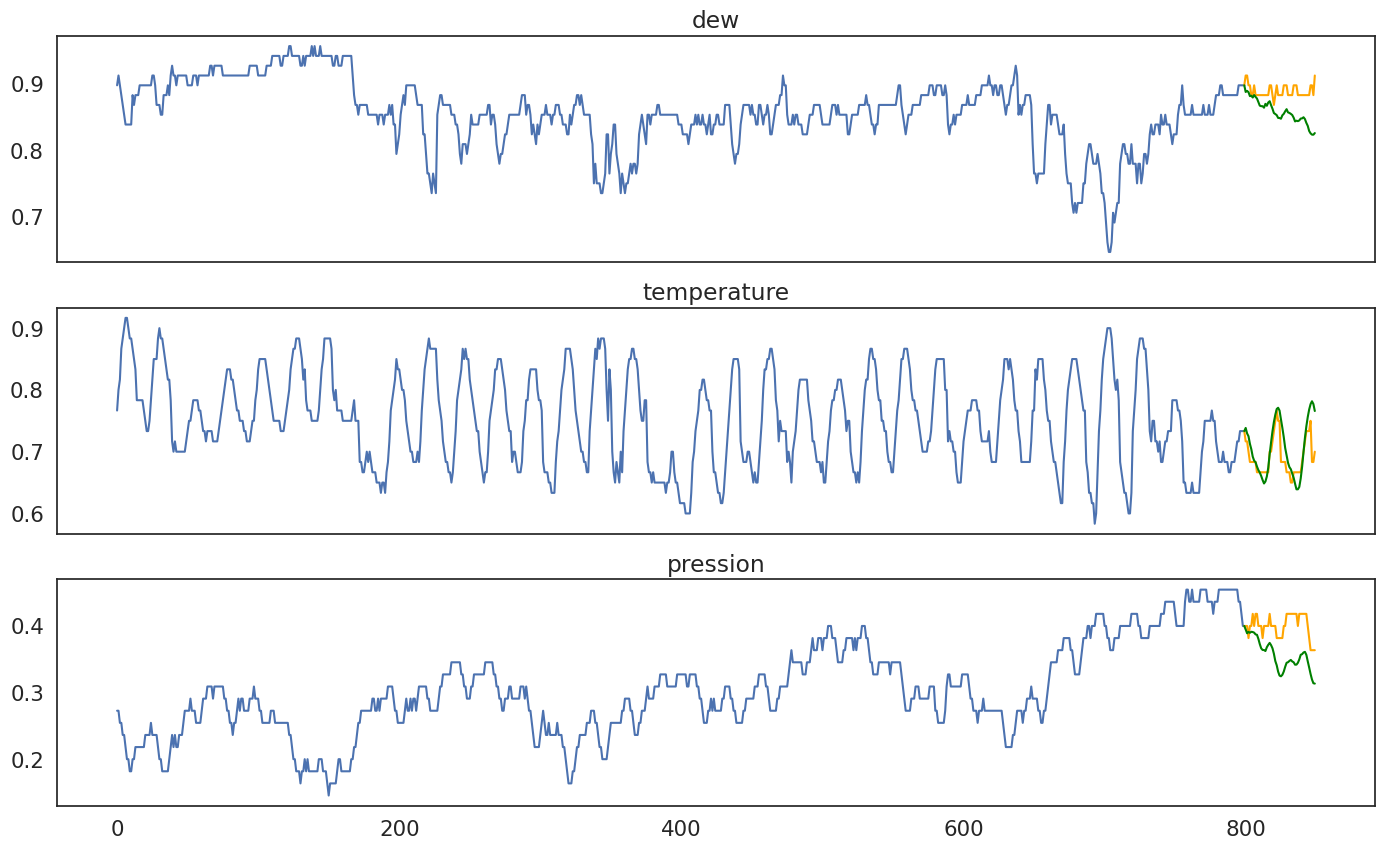

In [42]:
# Autoregressive prediction function
def autoregressive_predict(model, initial_sequence, num_steps, step_size, device):
    model.eval()
    predictions = []
    current_input = initial_sequence.clone()

    with torch.no_grad():
        for _ in range(0, num_steps, step_size):
            pred = model(current_input)
            predictions.append(pred.cpu().numpy())

            current_input = torch.cat([
                current_input[:, step_size:, :],
                pred
            ], dim=1)

    all_predictions = np.concatenate(predictions, axis=1)
    return all_predictions[:, :num_steps, :]

# Build validation sequences for 50-step prediction
X_val_direct, y_val_direct = build_sequences(
    X_val_raw,
    TARGET_LABELS,
    WINDOW_SIZE,
    STRIDE,
    direct_telescope
)

# Perform autoregressive prediction
val_predictions = []

for i in range(0, len(X_val_direct), BATCH_SIZE):
    batch_end = min(i + BATCH_SIZE, len(X_val_direct))
    inputs = torch.from_numpy(X_val_direct[i:batch_end]).to(device)

    preds = autoregressive_predict(
        model=rnn_model,
        initial_sequence=inputs,
        num_steps=direct_telescope,
        step_size=autoregressive_telescope,
        device=device
    )
    val_predictions.append(preds)

val_predictions = np.concatenate(val_predictions, axis=0)

# Calculate metrics
mse = np.mean((val_predictions - y_val_direct) ** 2)
rmse = np.sqrt(mse)

print(f"Validation Performance:")
print(f"  RMSE: {rmse:.6f}")

# Visualize results
inspect_multivariate_prediction(
    X_val_direct,
    y_val_direct,
    val_predictions,
    TARGET_LABELS,
    direct_telescope
)


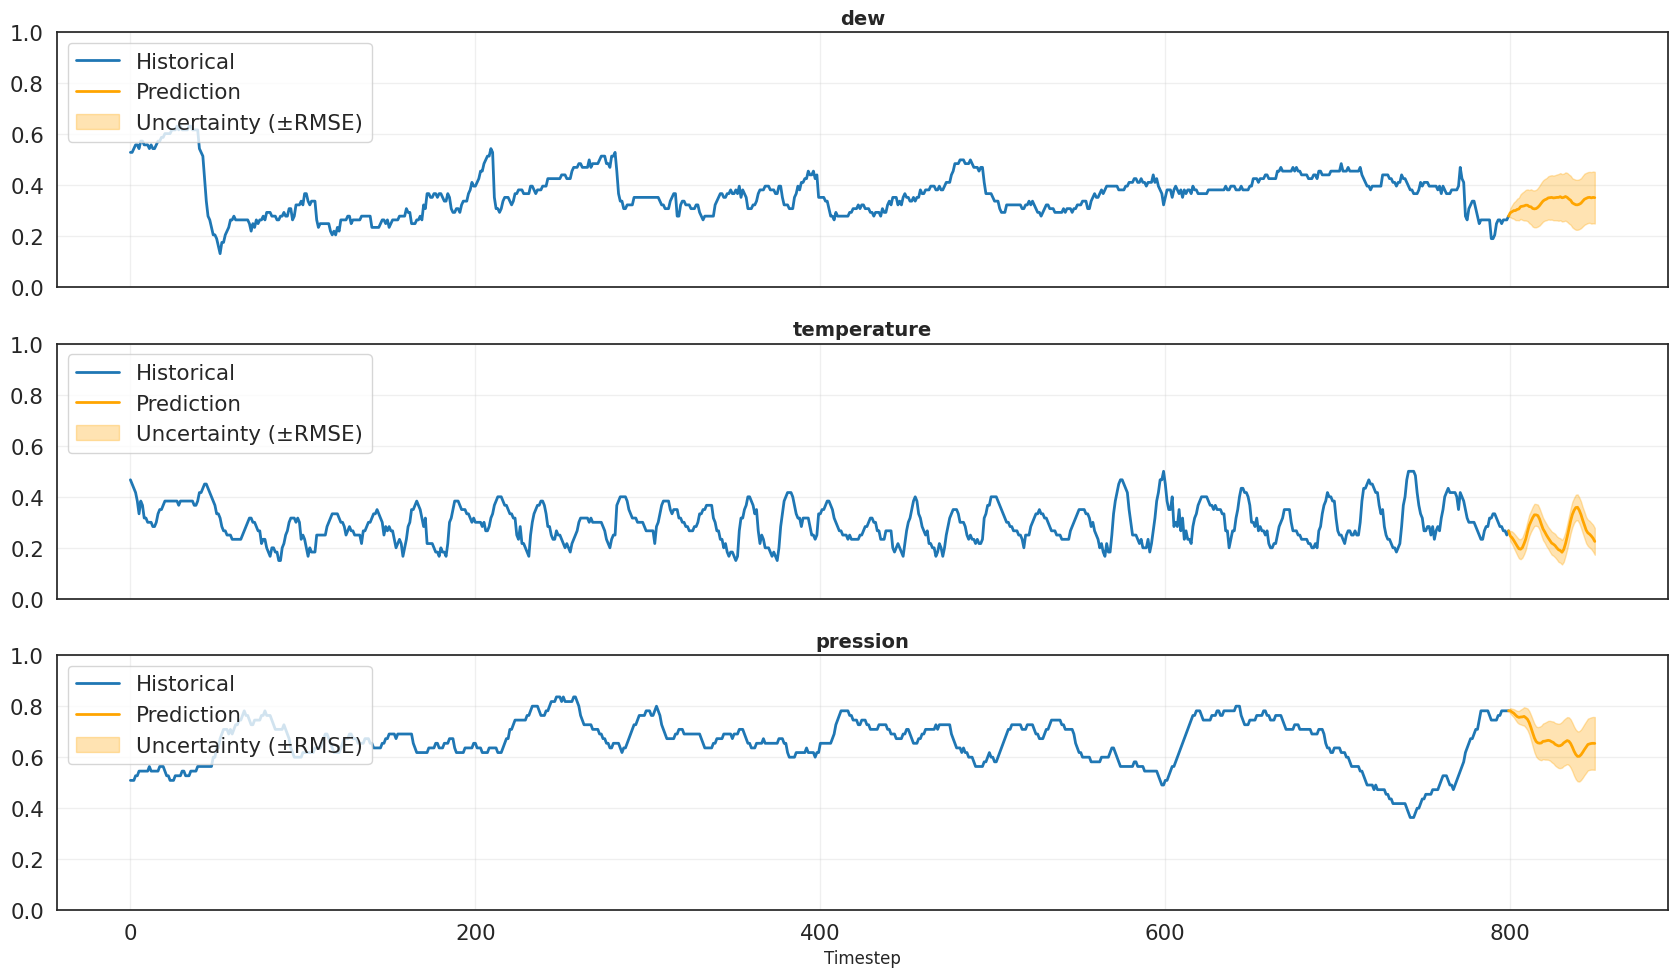

In [43]:
# ========================================
# Predictions on test set using Autoregressive Forecasting model
# ========================================
X_test_direct, y_test_direct = build_sequences(
    X_test_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, direct_telescope
)

# Perform autoregressive prediction
test_predictions = []

for i in range(0, len(X_test_direct), BATCH_SIZE):
    batch_end = min(i + BATCH_SIZE, len(X_test_direct))
    inputs = torch.from_numpy(X_test_direct[i:batch_end]).to(device)

    preds = autoregressive_predict(
        model=rnn_model,
        initial_sequence=inputs,
        num_steps=direct_telescope,
        step_size=autoregressive_telescope,
        device=device
    )
    test_predictions.append(preds)

test_predictions = np.concatenate(test_predictions, axis=0)

# ========================================
# Compute RMSE per timestep and feature
# ========================================
rmses = []
for i in range(test_predictions.shape[1]):
    ft_rmses = []
    for j in range(test_predictions.shape[2]):
        mse = np.mean((y_test_direct[:, i, j] - test_predictions[:, i, j]) ** 2)
        rmse = np.sqrt(mse)
        ft_rmses.append(rmse)
    rmses.append(np.array(ft_rmses))

rmses = np.array(rmses)

# ========================================
# Generate future predictions
# ========================================
future_predictions = autoregressive_predict(
    model=rnn_model,
    initial_sequence=torch.from_numpy(future).to(device),
    num_steps=direct_telescope,
    step_size=autoregressive_telescope,
    device=device
)

future_predictions = np.concatenate(
    [np.expand_dims(future[:, -1, :], axis=1), future_predictions],
    axis=1
)

rmses = np.concatenate([np.array([[0, 0, 0]]), rmses], axis=0)

# ========================================
# Visualize future predictions with uncertainty bounds
# ========================================
figs, axs = plt.subplots(len(TARGET_LABELS), 1, sharex=True, figsize=(17, 10))

for i, col in enumerate(TARGET_LABELS):
    axs[i].plot(
        np.arange(len(future[0, :, i])),
        future[0, :, i],
        label='Historical',
        color='#1f77b4',
        linewidth=2
    )

    axs[i].plot(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i],
        color='orange',
        label='Prediction',
        linewidth=2
    )

    axs[i].fill_between(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i] + rmses[:, i],
        future_predictions[0, :, i] - rmses[:, i],
        color='orange',
        alpha=0.3,
        label='Uncertainty (±RMSE)'
    )

    axs[i].set_title(col, fontsize=14, fontweight='bold')
    axs[i].set_ylim(0, 1)
    axs[i].grid(alpha=0.3)
    axs[i].legend(loc='upper left')

plt.xlabel('Timestep', fontsize=12)
plt.tight_layout()
plt.show()

## 🛠️ **Multivariate Sequence-To-Sequence Forecating (Autoregressive)**

<img src="https://drive.google.com/uc?export=view&id=1v4slQEVlkAkDoRUH8q28ftdOs-fQ9vd-" width="800"/>



In [44]:
# Build sequences and labels for training, validation, and test datasets
X_train, y_train = build_sequences(X_train_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, direct_telescope)
X_val, y_val = build_sequences(X_val_raw, TARGET_LABELS, WINDOW_SIZE, 1, direct_telescope)
X_test, y_test = build_sequences(X_test_raw, TARGET_LABELS, WINDOW_SIZE, 1, direct_telescope)

# Print the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7510, 800, 3),
 (7510, 50, 3),
 (2350, 800, 3),
 (2350, 50, 3),
 (2350, 800, 3),
 (2350, 50, 3))

In [45]:
# Define the output shape based on the training labels
output_shape = y_train.shape[1:]

# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 800, 3])
Labels batch shape: torch.Size([128, 50, 3])


In [46]:
class Seq2SeqForecaster(nn.Module):
    """
    Sequence-to-Sequence model with attention for forecasting.
    Encoder and Decoder use the same RNN type (RNN, LSTM, or GRU).
    Trained with teacher forcing during training.
    """
    def __init__(
            self,
            input_size,       # Number of features in the input
            hidden_size,      # Hidden state size
            num_layers,       # Number of stacked RNN layers
            output_timesteps, # Number of future timesteps to predict
            output_features,  # Number of features to predict
            rnn_type='GRU',   # 'RNN', 'LSTM', or 'GRU'
            dropout_rate=0.2,
            bidirectional=False  # Enable bidirectional RNN
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_timesteps = output_timesteps
        self.output_features = output_features
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]
        dropout_val = dropout_rate if num_layers > 1 else 0

        # --- Encoder ---
        self.encoder = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_val,
            bidirectional=bidirectional
        )

        # Encoder output size (accounting for bidirectional)
        encoder_output_size = hidden_size * self.num_directions

        # --- Attention Layer ---
        self.attention = nn.Linear(encoder_output_size + hidden_size, 1)

        # --- Decoder (always unidirectional for autoregressive generation) ---
        self.decoder = rnn_module(
            input_size=output_features + encoder_output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_val,
            bidirectional=False
        )

        # --- Output Layer ---
        self.fc_out = nn.Linear(hidden_size, output_features)

        # Project bidirectional encoder hidden to decoder hidden if needed
        if bidirectional:
            self.hidden_projection = nn.Linear(hidden_size * 2, hidden_size)

    def _project_encoder_hidden(self, hidden):
        """
        Project bidirectional encoder hidden state to unidirectional decoder hidden state.
        """
        if not self.bidirectional:
            return hidden

        if self.rnn_type == 'LSTM':
            # hidden is tuple (h, c)
            h, c = hidden
            # h, c shape: (num_layers * 2, batch_size, hidden_size)
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            h = h.view(self.num_layers, 2, -1, self.hidden_size)
            c = c.view(self.num_layers, 2, -1, self.hidden_size)
            # Concatenate forward and backward, then project
            h = self.hidden_projection(torch.cat([h[:, 0], h[:, 1]], dim=-1))
            c = self.hidden_projection(torch.cat([c[:, 0], c[:, 1]], dim=-1))
            return (h, c)
        else:
            # hidden shape: (num_layers * 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            # Concatenate forward and backward, then project
            hidden = self.hidden_projection(torch.cat([hidden[:, 0], hidden[:, 1]], dim=-1))
            return hidden

    def attention_mechanism(self, decoder_hidden, encoder_outputs):
        """
        Compute attention weights and context vector.
        decoder_hidden: (batch_size, hidden_size) - current decoder hidden state
        encoder_outputs: (batch_size, seq_len, encoder_output_size) - all encoder outputs
        Returns: context vector (batch_size, encoder_output_size)
        """
        batch_size, seq_len, encoder_output_size = encoder_outputs.size()

        # Repeat decoder hidden state for all encoder time steps
        decoder_hidden_repeated = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Concatenate decoder hidden with each encoder output
        combined = torch.cat([decoder_hidden_repeated, encoder_outputs], dim=2)

        # Compute attention scores
        attention_scores = self.attention(combined)

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)

        # Compute context vector as weighted sum of encoder outputs
        context = torch.sum(attention_weights * encoder_outputs, dim=1)

        return context

    def forward(self, x, target=None, teacher_forcing_ratio=0.5):
        """
        x: (batch_size, seq_length, input_size) - input sequence
        target: (batch_size, output_timesteps, output_features) - target sequence (for teacher forcing)
        teacher_forcing_ratio: probability of using teacher forcing during training
        """
        batch_size = x.size(0)

        # --- Encode ---
        encoder_outputs, hidden = self.encoder(x)
        # encoder_outputs: (batch_size, seq_len, hidden_size * num_directions)

        # Project encoder hidden state to decoder hidden state
        decoder_hidden = self._project_encoder_hidden(hidden)

        # --- Prepare decoder initial input ---
        decoder_input = x[:, -1:, :self.output_features]

        # Initialize outputs tensor
        outputs = torch.zeros(batch_size, self.output_timesteps, self.output_features).to(x.device)

        # --- Decode ---
        for t in range(self.output_timesteps):
            # Get decoder hidden state for attention
            if self.rnn_type == 'LSTM':
                decoder_hidden_state = decoder_hidden[0][-1]
            else:
                decoder_hidden_state = decoder_hidden[-1]

            # Compute attention context
            context = self.attention_mechanism(decoder_hidden_state, encoder_outputs)

            # Concatenate decoder input with context vector
            decoder_input_with_context = torch.cat([decoder_input, context.unsqueeze(1)], dim=2)

            # Pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input_with_context, decoder_hidden)

            # Generate prediction
            prediction = self.fc_out(decoder_output.squeeze(1))
            outputs[:, t, :] = prediction

            # Teacher forcing
            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = target[:, t:t+1, :]
            else:
                decoder_input = prediction.unsqueeze(1)

        return outputs

In [47]:
def train_one_epoch_seq2seq(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, teacher_forcing_ratio=0.5):
    """
    Perform one complete training epoch through the entire training dataset.
    Adapted for Regression (Forecasting) with Seq2Seq and Teacher Forcing.
    Calculates and reports RMSE.
    Optimizes on the provided criterion (assumed to be MSELoss).

    Args:
        model (nn.Module): The neural network model to train (seq2seq)
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        teacher_forcing_ratio (float): Probability of using teacher forcing (0.0 to 1.0)

    Returns:
        float: average_rmse - Training RMSE for this epoch
    """
    model.train()  # Set model to training mode

    running_mse_loss = 0.0

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            # Pass targets for teacher forcing during training
            predictions = model(inputs, targets, teacher_forcing_ratio=teacher_forcing_ratio)
            # Calculate the loss (e.g., MSE)
            loss = criterion(predictions, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        # We store the *squared* error (MSE) from the loss function
        running_mse_loss += loss.item() * inputs.size(0)

    # Calculate epoch metrics
    epoch_mse = running_mse_loss / len(train_loader.dataset)
    epoch_rmse = np.sqrt(epoch_mse) # Convert final MSE to RMSE for reporting

    return epoch_rmse


def validate_one_epoch_seq2seq(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.
    Adapted for Regression (Forecasting) with Seq2Seq.
    Calculates and reports RMSE.
    No teacher forcing during validation.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss (e.g., MSELoss)
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        float: average_rmse - Validation RMSE for this epoch
    """
    model.eval()  # Set model to evaluation mode

    running_mse_loss = 0.0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                # No teacher forcing during validation (teacher_forcing_ratio=0.0)
                predictions = model(inputs, teacher_forcing_ratio=0.0)
                # Calculate the loss (e.g., MSE)
                loss = criterion(predictions, targets)

            # Accumulate metrics
            running_mse_loss += loss.item() * inputs.size(0)

    # Calculate epoch metrics
    epoch_mse = running_mse_loss / len(val_loader.dataset)
    epoch_rmse = np.sqrt(epoch_mse) # Convert final MSE to RMSE for reporting

    return epoch_rmse


def fit_seq2seq(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, teacher_forcing_ratio=0.5, scheduler=None, # Added scheduler parameter
        evaluation_metric="val_rmse", mode='min', # Monitors val_rmse and minimizes
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.
    Adapted for Regression (Forecasting) with Seq2Seq and Teacher Forcing, using RMSE as the sole metric.

    Args:
        model (nn.Module): The neural network model to train (seq2seq)
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        teacher_forcing_ratio (float): Probability of using teacher forcing during training (default: 0.5)
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler (default: None)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_rmse")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'min')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Ensure models directory exists
    if (patience > 0 or restore_best_weights) and not os.path.exists("models"):
        os.makedirs("models")
        print("Created 'models' directory for saving model checkpoints.")

    model_path = os.path.join("models", f"{experiment_name}_model.pt")

    # Initialize metrics tracking
    training_history = {
        'train_rmse': [], 'val_rmse': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('inf') if mode == 'min' else float('-inf')
        best_epoch = 0

    print(f"Training {epochs} epochs with teacher forcing ratio: {teacher_forcing_ratio}...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_rmse = train_one_epoch_seq2seq(
            model, train_loader, criterion, optimizer, scaler, device,
            l1_lambda, l2_lambda, teacher_forcing_ratio
        )

        # Evaluate model on validation data without updating weights
        val_rmse = validate_one_epoch_seq2seq(
            model, val_loader, criterion, device
        )

        # Step the scheduler if provided (typically after validation)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_rmse)
            else:
                scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_rmse'].append(train_rmse)
        training_history['val_rmse'].append(val_rmse)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_rmse, val_rmse, model
            )
            # Log learning rate
            writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch)


        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                      f"Train: RMSE={train_rmse:.4f} | "
                      f"Val: RMSE={val_rmse:.4f} | "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            # We monitor the metric specified in 'evaluation_metric' (default: 'val_rmse')
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric < best_metric) if mode == 'min' else (current_metric > best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        try:
            model.load_state_dict(torch.load(model_path))
            print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        except FileNotFoundError:
            print(f"Warning: Could not find best model checkpoint at {model_path}. Using last model.")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), model_path)

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [48]:
seq2seq_model = Seq2SeqForecaster(
    input_size=input_shape[1],  # Number of features in the input
    hidden_size=HIDDEN_SIZE,          # Equivalent to 128 units in Keras
    num_layers=HIDDEN_LAYERS,             # Equivalent to the two LSTM layers
    output_timesteps=output_shape[0],
    output_features=output_shape[1], # We predict all features
    dropout_rate=DROPOUT_RATE,         # Dropout between LSTM layers (if num_layers > 1)
    rnn_type=MODEL_TYPE,
    bidirectional=BIDIRECTIONAL
).to(device)
recurrent_summary(seq2seq_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "seq2seq_lstm_forecaster"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(seq2seq_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(seq2seq_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
encoder (LSTM)            [[-1, 800, 256], [1, -1, 256]] 267,264        
attention (Linear)        [-1, 800, 1]                 513            
decoder (LSTM)            [[-1, 1, 256], [1, -1, 256]] 529,408        
fc_out (Linear)           [-1, 3]                      771            
Total params: 797,956
Trainable params: 797,956
Non-trainable params: 0
-------------------------------------------------------------------------------


In [ ]:
%%time
# Train model and track training history
# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Monitor a metric that should be minimized (RMSE)
    factor=0.1,        # Factor by which the learning rate will be reduced
    patience=max(10,PATIENCE//2),       # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6        # Minimum learning rate
)

seq2seq_model, training_history = fit_seq2seq(
    model=seq2seq_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    patience=PATIENCE,
    evaluation_metric="val_rmse",
    mode='min',
    restore_best_weights=True,
    writer=writer,  # Set to writer if you want TensorBoard logging
    verbose=1,
    experiment_name="seq2seq_lstm_forecaster",
    teacher_forcing_ratio=0.5,
    scheduler=scheduler # Pass the scheduler to the fit function
)

Training 500 epochs with teacher forcing ratio: 0.5...
Epoch   1/500 | Train: RMSE=0.2043 | Val: RMSE=0.0918 | LR: 0.001000
Epoch   2/500 | Train: RMSE=0.0947 | Val: RMSE=0.0777 | LR: 0.001000
Epoch   3/500 | Train: RMSE=0.0810 | Val: RMSE=0.0839 | LR: 0.001000
Epoch   4/500 | Train: RMSE=0.0758 | Val: RMSE=0.0688 | LR: 0.001000
Epoch   5/500 | Train: RMSE=0.0690 | Val: RMSE=0.0733 | LR: 0.001000
Epoch   6/500 | Train: RMSE=0.0646 | Val: RMSE=0.0778 | LR: 0.001000
Epoch   7/500 | Train: RMSE=0.0648 | Val: RMSE=0.1016 | LR: 0.001000
Epoch   8/500 | Train: RMSE=0.0666 | Val: RMSE=0.0880 | LR: 0.001000
Epoch   9/500 | Train: RMSE=0.0552 | Val: RMSE=0.0720 | LR: 0.001000
Epoch  10/500 | Train: RMSE=0.0543 | Val: RMSE=0.0691 | LR: 0.001000
Epoch  11/500 | Train: RMSE=0.0552 | Val: RMSE=0.0857 | LR: 0.001000
Epoch  12/500 | Train: RMSE=0.0483 | Val: RMSE=0.0720 | LR: 0.001000
Epoch  13/500 | Train: RMSE=0.0423 | Val: RMSE=0.0731 | LR: 0.001000
Epoch  14/500 | Train: RMSE=0.0476 | Val: RMSE=0

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

# Plot of training and validation RMSE
ax1.plot(training_history['train_rmse'], label='Training RMSE', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_rmse'], label='Validation RMSE', alpha=0.9, color='#ff7f0e')
ax1.set_title('Root Mean Squared Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('RMSE')
ax1.legend()
ax1.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Define a function to inspect multivariate predictions versus ground truth
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    # Select a random index if none is provided
    if idx is None:
        idx = np.random.randint(0, len(X))

    # Prepare prediction and ground truth by concatenating the last known point
    pred = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), pred], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1, :], axis=1), y], axis=1)

    # Create subplots for visualisation
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 10))

    # Iterate through each column and plot actual, true, and predicted values
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])  # Plot historical data
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    y[idx, :, i], color='orange', label='Ground Truth')  # Plot ground truth
        axs[i].plot(np.arange(len(X[0, :, i]) - 1, len(X[0, :, i]) + telescope),
                    pred[idx, :, i], color='green', label='Prediction')  # Plot predictions
        axs[i].set_title(col)

    # Display the plots
    plt.show()

# Make predictions on validation set
seq2seq_model.eval()
val_predictions = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        preds = seq2seq_model(inputs)
        val_predictions.append(preds.cpu().numpy())

# Concatenate all predictions
val_predictions = np.concatenate(val_predictions, axis=0)

# Calculate validation performance
val_mse = np.mean((val_predictions - y_val) ** 2)
val_rmse = np.sqrt(val_mse)

print(f"Validation Performance:")
print(f"  RMSE: {val_rmse:.6f}")

# Inspect multivariate predictions versus ground truth using the validation data
inspect_multivariate_prediction(X_val, y_val, val_predictions, TARGET_LABELS, direct_telescope)

In [ ]:
# ========================================
# Predictions on test set using Direct Forecasting model
# ========================================
X_test_direct, y_test_direct = build_sequences(
    X_test_raw, TARGET_LABELS, WINDOW_SIZE, STRIDE, direct_telescope
)
test_ds_direct = TensorDataset(torch.from_numpy(X_test_direct), torch.from_numpy(y_test_direct))
test_loader_direct = make_loader(test_ds_direct, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

seq2seq_model.eval()
test_predictions = []

with torch.no_grad():
    for inputs, _ in test_loader_direct:
        inputs = inputs.to(device)
        preds = seq2seq_model(inputs)
        test_predictions.append(preds.cpu().numpy())

test_predictions = np.concatenate(test_predictions, axis=0)

# ========================================
# Compute RMSE per timestep and feature
# ========================================
rmses = []
for i in range(test_predictions.shape[1]):
    ft_rmses = []
    for j in range(test_predictions.shape[2]):
        mse = np.mean((y_test_direct[:, i, j] - test_predictions[:, i, j]) ** 2)
        rmse = np.sqrt(mse)
        ft_rmses.append(rmse)
    rmses.append(np.array(ft_rmses))

rmses = np.array(rmses)

# ========================================
# Generate future predictions
# ========================================
future_predictions = seq2seq_model(torch.from_numpy(future).to(device))
future_predictions = future_predictions.cpu().detach().numpy()

future_predictions = np.concatenate(
    [np.expand_dims(future[:, -1, :], axis=1), future_predictions],
    axis=1
)

rmses = np.concatenate([np.array([[0, 0, 0]]), rmses], axis=0)

# ========================================
# Visualize future predictions with uncertainty bounds
# ========================================
figs, axs = plt.subplots(len(TARGET_LABELS), 1, sharex=True, figsize=(17, 10))

for i, col in enumerate(TARGET_LABELS):
    axs[i].plot(
        np.arange(len(future[0, :, i])),
        future[0, :, i],
        label='Historical',
        color='#1f77b4',
        linewidth=2
    )

    axs[i].plot(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i],
        color='orange',
        label='Prediction',
        linewidth=2
    )

    axs[i].fill_between(
        np.arange(len(future[0, :, i]) - 1, len(future[0, :, i]) + direct_telescope),
        future_predictions[0, :, i] + rmses[:, i],
        future_predictions[0, :, i] - rmses[:, i],
        color='orange',
        alpha=0.3,
        label='Uncertainty (±RMSE)'
    )

    axs[i].set_title(col, fontsize=14, fontweight='bold')
    axs[i].set_ylim(0, 1)
    axs[i].grid(alpha=0.3)
    axs[i].legend(loc='upper left')

plt.xlabel('Timestep', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

<img src="https://drive.google.com/uc?export=view&id=1gWxnQ1RkH9j9zX_iPUcG4cP_MOfo7PgR" width="700"/>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

##### Connect with us:
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="14"> **LinkedIn:**  [AIRLab Polimi](https://www.linkedin.com/company/airlab-polimi/)
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="14"> **Instagram:** [airlab_polimi](https://www.instagram.com/airlab_polimi/)

##### Contributors:
- **Eugenio Lomurno**: eugenio.lomurno@polimi.it
- **Alberto Archetti**: alberto.archetti@polimi.it
- **Roberto Basla**: roberto.basla@polimi.it
- **Carlo Sgaravatti**: carlo.sgaravatti@polimi.it

```
   Copyright 2025 Eugenio Lomurno, Alberto Archetti, Roberto Basla, Carlo Sgaravatti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```
